In [5]:
"""
Further suppose that the dataset is ticker-tagged for 200 equities which respond to the dataset in roughly similar ways. Maybe the economic basis of the data is shared by all the equities, or maybe investor trading behavior on the data unites them.

"""

import numpy as np
import pandas as pd

# simulate the returns and signal
r = 0 # avg return
r_sig = 1 # avg return conditioned on signal
sigma_alpha = 0.5 # alpha std dev
sigma_beta = 0.3 # beta std dev
rho = 0.4 # correlation between alpha and beta

# Means
Mu = np.array([r, r_sig])

# covariance
Cov = np.diag([r, r_sig]) @ np.array([1,rho,rho,1]).reshape(2,2) @ np.diag([r, r_sig])

print(Mu)
print(Cov)

[0 1]
[[0. 0.]
 [0. 1.]]


In [6]:
"""
More formally we can say the alt dataset comprises an explanatory factor portfolio, and the equity returns have betas to that factor. That implies a covariance structure between the equities we can exploit for superior signal construction. So we continue simulating this data...
"""

# generate population equity data
m_symbols = 200

np.random.seed(60)
mvr = np.random.multivariate_normal(Mu, Cov, m_symbols)

alpha_ret = mvr[:,0]
beta_ret = mvr[:,1]

print(mvr)

[[ 0.00000000e+00  7.82290068e-02]
 [ 0.00000000e+00  2.16399914e+00]
 [ 0.00000000e+00 -9.85230222e-01]
 [ 0.00000000e+00  1.73780706e+00]
 [ 0.00000000e+00  1.00098920e+00]
 [ 0.00000000e+00  5.66928230e-02]
 [ 0.00000000e+00  3.28128940e+00]
 [ 0.00000000e+00  3.25431330e-01]
 [ 0.00000000e+00  2.16688402e+00]
 [ 0.00000000e+00  1.56085277e+00]
 [ 0.00000000e+00  1.26504290e+00]
 [ 0.00000000e+00  9.71338559e-01]
 [ 0.00000000e+00  2.31209035e+00]
 [ 0.00000000e+00  1.83976096e+00]
 [ 0.00000000e+00  1.03828951e+00]
 [ 0.00000000e+00  9.95761801e-01]
 [ 0.00000000e+00  2.61205379e-01]
 [ 0.00000000e+00  1.38605227e+00]
 [ 0.00000000e+00  2.20804571e+00]
 [ 0.00000000e+00  1.06039108e+00]
 [ 0.00000000e+00  2.97494604e+00]
 [ 0.00000000e+00  2.11886785e+00]
 [ 0.00000000e+00  1.82823957e+00]
 [ 0.00000000e+00  2.78969486e-03]
 [ 0.00000000e+00 -6.61805786e-01]
 [ 0.00000000e+00  1.02921621e+00]
 [ 0.00000000e+00  1.98127379e+00]
 [ 0.00000000e+00 -7.76268737e-01]
 [ 0.00000000e+00  1

In [32]:
# simulate 50 return samples for each symbol - train set

np.random.seed(64)
n_samples = 50

event = np.random.uniform(0,1, int(n_samples * m_symbols))
sym_id = np.repeat(list(range(1, m_symbols + 1)), n_samples)
mu = alpha_ret[sym_id - 1] + beta_ret[sym_id - 1] * event
sigma = 0.5

ret = np.random.normal(mu, sigma, m_symbols * n_samples)
train_df = pd.DataFrame({'symbol': sym_id, 'event':event, 'ret': ret})
train_df

,symbol,event,ret
0,1,0.379099,0.756684
1,1,0.567098,0.179317
2,1,0.595593,0.153995
3,1,0.449859,0.289180
4,1,0.457020,0.542984
...,...,...,...
9995,200,0.283286,-0.565858
9996,200,0.727756,0.203937
9997,200,0.894205,0.410976
9998,200,0.476636,0.578224


In [9]:
"""
Now we have a train set and a test set. First let's try fitting an OLS model to each equity based on only its sample of the data, individually. We'll estimate the model on the train set, then evaluate it via MSE on the test set (MSE chosen over MAE to penalize very high errors).
"""

# simulate 20 return samples for each symbol - test set

np.random.seed(32)
n_samples = 20

event = np.random.uniform(0,1, int(n_samples * m_symbols))
sym_id = np.repeat(list(range(1, m_symbols + 1)), n_samples)
mu = alpha_ret[sym_id - 1] + beta_ret[sym_id - 1] * event
sigma = 0.5

ret = np.random.normal(mu, sigma, m_symbols * n_samples)
test_df = pd.DataFrame({'symbol': sym_id, 'event':event, 'ret': ret})
test_df

,symbol,event,ret
0,1,0.858889,-0.367231
1,1,0.372711,0.050432
2,1,0.555129,-0.700390
3,1,0.955657,-0.065072
4,1,0.736670,1.001676
...,...,...,...
3995,200,0.609586,0.508781
3996,200,0.275635,0.239987
3997,200,0.103813,0.471563
3998,200,0.885118,0.538072


In [10]:
"""
We evaluate the per-symbol models ("no pooling") and average their MSEs, then evaluate out of sample on the entire dataset ("complete pooling"). Per-symbol the average MSE is ~0.604, total is 1.21. Can we do better than this? Let's try estimating the model with complete pooling.
"""

import statsmodels.api as sm

symbol_mse = []
total_y = []
total_y_hat = []
rsq = []
pval = []

for symbol in train_df['symbol'].drop_duplicates().to_list():
    train_data = train_df.loc[train_df['symbol'] == symbol][['event', 'ret']].to_numpy()
    y = train_data.T[1].reshape(-1,1)
    X = sm.add_constant(train_data.T[0])
    model = sm.OLS(y, X).fit()
    rsq.append(model.rsquared)
    pval.append(model.pvalues)

    # evaluate the model via MSE
    test_data = test_df.loc[test_df['symbol'] == symbol][['event', 'ret']].to_numpy()
    y = test_data.T[1].reshape(-1,1)
    X = sm.add_constant(test_data.T[0])

    y_hat = model.predict(exog=X)

    mse = np.square(y - y_hat).mean()
    total_y += [k for k in y]
    total_y_hat += [k for k in y_hat]
    symbol_mse.append(mse)

# measure avg of MSE across per-symbol models
np.mean(symbol_mse)


0.6045999327511623

In [11]:
# also measure MSE across entire dataset - no pooling performs much worse on entire dataset than per-symbol

np.square(np.array(total_y) - np.array(total_y_hat)).mean()

1.2134402679058207

In [12]:
"""
The model estimates the alt dataset's signal across the entire sample of equities without any conditioning on equities. MSEs on a per-symbol basis are worse than before, but the total dataset MSE has improved. Can we do better than this?
"""

pooled_mse = []

train_data = train_df[['event', 'ret']].to_numpy()
y = train_data.T[1].reshape(-1,1)
X = sm.add_constant(train_data.T[0])
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     1425.
Date:                Thu, 13 Jun 2024   Prob (F-statistic):          1.22e-291
Time:                        13:56:41   Log-Likelihood:                -11933.
No. Observations:               10000   AIC:                         2.387e+04
Df Residuals:                    9998   BIC:                         2.389e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0077      0.016     -0.485      0.6

In [13]:
for symbol in train_df['symbol'].drop_duplicates().to_list():
    # evaluate the model via MSE

    test_data = test_df.loc[test_df['symbol'] == symbol][['event', 'ret']].to_numpy()
    y = test_data.T[1].reshape(-1,1)
    X = sm.add_constant(test_data.T[0])

    #y_hat = X @ model.params.T
    y_hat = model.predict(exog=X)

    mse = np.square(y - y_hat).mean()
    pooled_mse.append(mse)

np.mean(pooled_mse)

0.7995235612194488

In [14]:
# also measure MSE across entire dataset - total pooling performs much better on entire dataset than per-symbol

X = sm.add_constant(test_df['event'].to_numpy())
y_hat = model.predict(X)
np.square(y-y_hat).mean()

0.46133958908871653

In [15]:
"""
In fact, we can fit a multilevel regression model instead. The "fixed effects" have an interpretation as the completely pooled regression coefficient, and the "random effects" are per-symbol deviations. To make a per-symbol prediction, we sum the effects. The MSEs improve.
"""

import statsmodels.formula.api as smf

# build mixed effects model - partial pooling on symbols

model = smf.mixedlm('ret ~ event', train_df, groups=train_df['symbol'])
md = model.fit()
re = {symbol: md.random_effects[symbol][0] for symbol in md.random_effects}
test_df['fe'] = md.predict(exog=test_df)
test_df['re'] = test_df['symbol'].map(re)
test_df['ret_hat'] = test_df['fe'] + test_df['re']

# evaluate the model per-symbol - it outperforms both the unpooled and completely pooled versions

mse = []

for symbol in test_df['symbol'].drop_duplicates().to_list():
    test_data = test_df.loc[test_df['symbol'] == symbol]
    sym_mse = np.square(test_data['ret'] - test_data['ret_hat']).mean()
    mse.append(sym_mse)

np.mean(mse)

C:\Users\alec\AppData\Local\Temp\ipykernel_29560\688415733.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  re = {symbol: md.random_effects[symbol][0] for symbol in md.random_effects}


0.3465367586251309

In [16]:
# evaluate the MSE across the entire dataset - it outperforms both the unpooled and completely pooled versions

me_mse = np.square(test_df['ret'] - test_df['ret_hat']).mean()
me_mse

0.3465367586251309

In [35]:
"""
Aside from improved out-of-sample accuracy, this comes with an elegant basis for portfolio construction. The random effects have a natural interpretation as the relative out (under) performance of each symbol, neutral to the group/cluster on which the model was estimated.

So for each alt dataset with which this modeling approach works, you can simple sort by random effects in each group, long the top decile of random effects, short the bottom decile of random effects, and hedge the remainder to trade a neutral basket.
"""

import quantstats as qs

# Sort within each symbol group by random effects
train_df = train_df.sort_values(by=['event'])

# Define function to classify deciles
def classify_decile(group):
    group['decile'] = pd.qcut(group['event'], 10, labels=False)
    return group

# Apply the function to the DataFrame
train_df = train_df.groupby('symbol', group_keys=False).apply(classify_decile)

# Create long and short positions
train_df['position'] = 0
train_df.loc[train_df['decile'] == 9, 'position'] = 1  # Long top decile
train_df.loc[train_df['decile'] == 0, 'position'] = -1  # Short bottom decile

# Hedge the remainder to trade a neutral basket
train_df['hedged_position'] = train_df.groupby('symbol')['position'].transform(lambda x: x - x.mean())

# Calculate the strategy returns
train_df['strategy_ret'] = train_df['hedged_position'] * train_df['ret']

# Aggregate strategy returns
strategy_returns = train_df.groupby('symbol')['strategy_ret'].sum()

# Convert to cumulative returns for QuantStats analysis
strategy_returns

C:\Users\alec\AppData\Local\Temp\ipykernel_29560\3888312325.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('symbol', group_keys=False).apply(classify_decile)


symbol
1       0.813416
2      10.827506
3      -5.687411
4       9.846481
5       5.026724
         ...    
196    11.671410
197     1.697227
198     1.975334
199    -0.024482
200     0.902371
Name: strategy_ret, Length: 200, dtype: float64

<Axes: xlabel='symbol'>

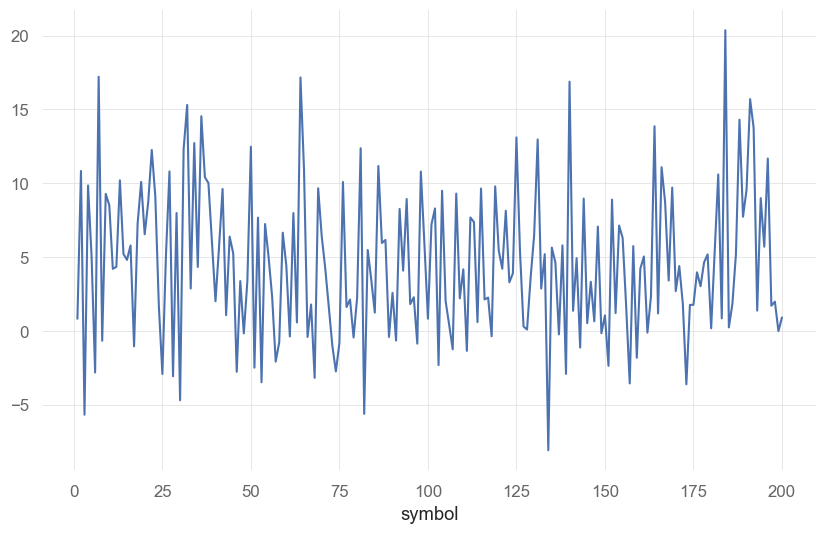

In [36]:
strategy_returns.plot()